## Exercise 1

 - Import Barcelona_air_pollution data
 - Find the most interessting series to predict
 - Is it stationary? Is it seasonal?
 - Predict and validate the pollution for the last 6 months
 - Use wind_speed from weather data to improve your prediction

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [ ]:
air_pol = pd.read_csv('/content/sample_data/Barcelona_air_pollution.csv', sep = ';')
air_pol['date_hour0'] = air_pol['date'] + ' ' + air_pol['hour'].astype(str)
air_pol['date_hour'] = pd.to_datetime(air_pol['date_hour0'], format = '%d/%m/%Y %H')
air_pol.drop(['date','hour','date_hour0'], axis = 1, inplace = True)
air_pol.tail(5)

,lon,lat,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,aqi,year,city,date_hour
17324,41.3888,2.159,216.96,0.0,0.07,40.05,0.05,2.71,5.42,0.37,1,2022,Barcelona,2022-12-31 20:00:00
17325,41.3888,2.159,216.96,0.0,0.07,38.98,0.05,3.10,6.23,0.40,1,2022,Barcelona,2022-12-31 21:00:00
17326,41.3888,2.159,213.62,0.0,0.07,41.13,0.09,4.61,9.95,0.41,1,2022,Barcelona,2022-12-31 22:00:00
17327,41.3888,2.159,210.29,0.0,0.06,45.06,0.11,5.32,12.26,0.36,1,2022,Barcelona,2022-12-31 23:00:00
17328,41.3888,2.159,213.62,0.0,0.06,48.64,0.09,4.33,10.00,0.30,1,2023,Barcelona,2023-01-01 00:00:00


In [ ]:
weather = pd.read_csv('/content/sample_data/Barcelona_weather.csv', sep = ';')
weather['date'] = pd.to_datetime(weather['dt'],unit='s')
weather = weather[['date','temp','feels_like','pressure','humidity','wind_speed','rain_1h']]
weather['rain_1h'].fillna(0, inplace = True)
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather

,date,temp,feels_like,pressure,humidity,wind_speed,rain_1h,year,month
0,2018-01-01 00:00:00,14.63,13.61,1018,56,9.30,0.0,2018,1
1,2018-01-01 01:00:00,13.31,12.05,1019,52,6.70,0.0,2018,1
2,2018-01-01 02:00:00,12.35,11.10,1020,56,6.70,0.0,2018,1
3,2018-01-01 03:00:00,10.77,9.23,1021,51,7.72,0.0,2018,1
4,2018-01-01 04:00:00,11.96,10.60,1022,53,8.75,0.0,2018,1
...,...,...,...,...,...,...,...,...,...
44504,2023-01-01 19:00:00,12.73,12.41,1025,90,1.54,0.0,2023,1
44505,2023-01-01 20:00:00,12.28,11.91,1025,90,3.10,0.0,2023,1
44506,2023-01-01 21:00:00,12.28,11.86,1024,88,4.10,0.0,2023,1
44507,2023-01-01 22:00:00,11.96,11.48,1024,87,4.10,0.0,2023,1


In [ ]:
air_pol = air_pol.merge(weather, left_on = 'date_hour', right_on = 'date', how = 'left')
air_pol.columns

Index(['lon', 'lat', 'CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3',
       'aqi', 'year_x', 'city', 'date_hour', 'date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'rain_1h', 'year_y', 'month'],
      dtype='object')

<Figure size 1200x700 with 0 Axes>

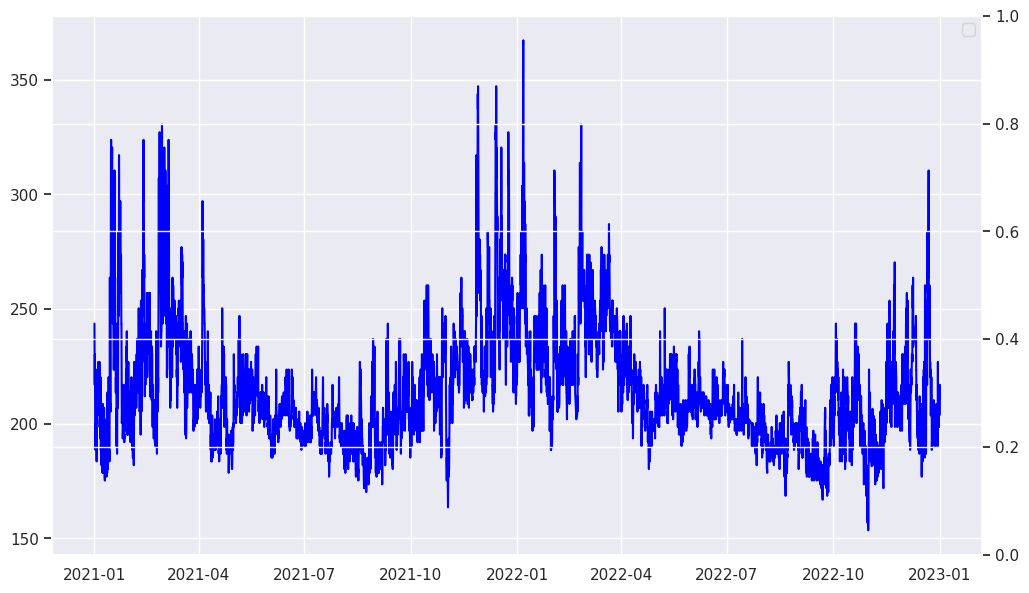

In [ ]:
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
# sns.lineplot(data = air_pol, x = 'date_hour', y = 'CO')
# ax.plt.plot(air_pol['date_hour'], air_pol['PM10'])
# ax.plt.plot(air_pol['date_hour'], air_pol['PM2_5'])
# ax2.plt.plot(air_pol['date_hour'], air_pol['CO'])
# plt.xticks(rotation=45);

# ax.plot(air_pol['date_hour'], air_pol['PM10'], color = 'red', label = 'PM10')
# ax.plot(air_pol['date_hour'], air_pol['PM2_5'], color = 'green', label = 'PM2.5')
ax.plot(air_pol['date_hour'], air_pol['CO'], color = 'blue', label = 'CO')
plt.legend()
plt.xticks(rotation=45);


In [ ]:
air_plot_train = air_pol[air_pol['date_hour']<='2022-10-31 23:00:0']
air_plot_test = air_pol[air_pol['date_hour']>'2022-10-31 23:00:0']

air_plot_train.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'month'], axis = 1, inplace = True)
air_plot_test.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'month'], axis = 1, inplace = True)

air_plot_train.columns = ['y', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','ds', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed']
air_plot_test.columns = ['y', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','ds', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed']

# air_plot_train['y'] = air_plot_train['y'].rolling(window=24).mean()
# air_plot_train['y'] = np.log(air_plot_train['y'])
air_plot_train


,y,NO,NO2,O3,SO2,PM2_5,PM10,NH3,ds,temp,feels_like,pressure,humidity,wind_speed
0,243.66,0.0,0.07,41.84,0.07,5.12,11.97,0.41,2021-01-01 00:00:00,9.11,8.43,1007,71,1.70
1,233.65,0.0,0.08,44.35,0.07,5.52,14.40,0.38,2021-01-01 01:00:00,8.46,7.31,1006,73,2.10
2,226.97,0.0,0.08,46.49,0.06,5.83,16.02,0.34,2021-01-01 02:00:00,8.14,6.94,1006,75,2.10
3,223.64,0.0,0.08,46.49,0.06,6.08,16.92,0.30,2021-01-01 03:00:00,6.98,4.51,1006,79,3.60
4,220.30,0.0,0.09,46.49,0.06,6.44,17.89,0.26,2021-01-01 04:00:00,6.89,4.40,1006,80,3.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16105,223.64,0.0,0.06,14.31,0.02,0.65,0.99,0.26,2022-10-31 19:00:00,20.84,21.25,1019,87,2.57
16106,216.96,0.0,0.07,12.87,0.03,0.76,1.12,0.25,2022-10-31 20:00:00,20.80,21.21,1019,87,2.57
16107,208.62,0.0,0.08,12.70,0.03,0.81,1.12,0.22,2022-10-31 21:00:00,20.74,21.14,1019,87,1.54
16108,205.28,0.0,0.08,13.41,0.03,0.85,1.14,0.20,2022-10-31 22:00:00,20.83,21.08,1020,81,3.60
